In [1]:
import pandas as pd
import glob
import os
import xlrd
import unicodedata
import time
import seaborn as sns
sns.set_style("whitegrid")
import plotly.plotly as py
from plotly.graph_objs import *

%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
xl_file = pd.ExcelFile('Phase2_all_raw.xls')
df_exp = xl_file.parse('noout').drop(['filename', 'TID', 'index'], 1)
df_exp.head()

CT         H         M  UID Experiment  Session Intervention Time   Group
0   75  0.827365  0.013319  S01         ct      1.1      Control  Pre  intact
1  100  1.199134  0.013854  S01         ct      1.1      Control  Pre  intact
2  100  1.240342  0.027640  S01         ct      1.1      Control  Pre  intact
3  100  1.097617  0.019150  S01         ct      1.1      Control  Pre  intact
4    0  0.878786  0.016717  S01         ct      1.1      Control  Pre  intact

In [3]:
# CALCULATE MEDIANS
df_median = df_exp.groupby(['Group', 'UID', 'Intervention', 'Time', 'CT']).median()
df_median.head()

H         M  Session
Group UID Intervention Time CT                              
csci  C01 Control      Post 0    0.613378  0.014817      1.2
                            25   0.351827  0.012170      1.2
                            50   0.605786  0.015831      1.2
                            75   0.563766  0.012088      1.2
                            100  0.594111  0.014501      1.2

In [4]:
# NORMALIZE EVERY SINGLE MEASURE IN THE DATASET

df_medind = df_median.reset_index().set_index(['Group', 'UID', 'Intervention', 'Time', 'CT'])

df_allnorm = pd.DataFrame()
for index, row in df_exp.iterrows():
    row.H = 100 * row.H/df_medind.loc[row.Group, row.UID, row.Intervention, row.Time, 0].H
    row.M = 100 * row.M/df_medind.loc[row.Group, row.UID, row.Intervention, row.Time, 0].M
    
    df_allnorm = df_allnorm.append(row)

def flat_var(df, v):
    df_flat = df.unstack([v])
    df_flat.columns = [' '.join(col) for col in df_flat.columns.values]
    return df_flat

#flat_me(df_allnorm.reset_index())
df = df_allnorm.drop(['Experiment', 'Session'], 1)
df['cindex'] = df.groupby(['Group', 'UID', 'Intervention', 'CT', 'Time']).cumcount()
df = df.set_index(['Group', 'UID', 'Intervention', 'CT', 'Time', 'cindex'])
df = flat_var(df, 'Intervention')
df = flat_var(df, 'Time')

df_allnorm = df.reset_index().drop('cindex', 1)
df_allnorm.head()

Group  UID  CT  H Control Post  H Control Pre  H Cycling Post  \
0  csci  C01   0       94.756940      98.485679       99.559517   
1  csci  C01   0      105.207793      88.904615      106.812459   
2  csci  C01   0       95.164660      93.401136      103.592095   
3  csci  C01   0      102.774291      94.629779      100.440483   
4  csci  C01   0       93.687767      90.447136      101.908149   

   H Cycling Pre  H ES Cycling Post  H ES Cycling Pre  M Control Post  \
0      42.647559         107.079493         94.756940       94.706991   
1      99.697012         100.000000        105.207793      114.325349   
2     130.646948         110.433551         95.164660      100.766374   
3     115.940990         105.023007        102.774291       94.938365   
4     115.179180         104.233399         93.687767       73.227228   

   M Control Pre  M Cycling Post  M Cycling Pre  M ES Cycling Post  \
0      98.961511      105.400952     106.833667          93.116776   
1     128.852249      121.068998      98.671206         122.371919   
2      97.747929      131.412660      99.835903          84.938874   
3     124.368203       93.283314     120.085966         106.069961   
4      73.625969      110.263359     102.443438         138.793453   

   M ES Cycling Pre  
0         94.706991  
1        114.325349  
2        100.766374  
3         94.938365  
4         73.227228

In [5]:
df = df_allnorm.drop('UID', 1)
dg = df.groupby(['Group', 'CT'])
dmedian = dg.median()
dsem = dg.sem()
dsem.columns = dsem.columns + ' sem'
dmedian = pd.concat([dmedian, dsem], axis = 1)
dmedian = dmedian[sorted(dmedian.columns)]

dmedian.head()

H Control Post  H Control Post sem  H Control Pre  \
Group CT                                                       
csci  0        100.000000            1.281997     100.000000   
      25        99.330345            2.392712      96.552071   
      50       104.103839            1.379704     105.164463   
      75       101.489069            1.574926     105.531374   
      100      102.473730            1.217245     105.357966   

           H Control Pre sem  H Cycling Post  H Cycling Post sem  \
Group CT                                                           
csci  0             0.925746      100.000000            0.843326   
      25            2.484296       97.010091            1.009173   
      50            1.830781      101.692742            1.368625   
      75            2.173728      101.279966            1.067042   
      100           1.471734      102.293258            1.135922   

           H Cycling Pre  H Cycling Pre sem  H ES Cycling Post  \
Group CT                                                         
csci  0       100.000000           2.052512         100.000000   
      25       96.179476           2.264021          98.944307   
      50      105.369987           2.649232         100.039342   
      75      104.251220           2.056859          98.290920   
      100     104.516531           2.337498          99.591771   

           H ES Cycling Post sem          ...           M Control Pre  \
Group CT                                  ...                           
csci  0                 1.362919          ...              100.000000   
      25                2.122491          ...               97.770710   
      50                1.769641          ...               98.517165   
      75                1.604393          ...              100.355084   
      100               1.410155          ...              100.068803   

           M Control Pre sem  M Cycling Post  M Cycling Post sem  \
Group CT                                                           
csci  0             2.133263      100.000000            2.009420   
      25            2.665344       94.179127            1.725856   
      50            2.140680       94.189559            1.915557   
      75            1.780093       99.087606            1.767212   
      100           2.958572       96.161997            2.262703   

           M Cycling Pre  M Cycling Pre sem  M ES Cycling Post  \
Group CT                                                         
csci  0       100.000000           1.964632         100.000000   
      25       96.203335           1.838974         100.551399   
      50      100.348558           2.210622         104.850725   
      75      102.651594           2.316085         102.167429   
      100     102.036352           2.138665         103.674855   

           M ES Cycling Post sem  M ES Cycling Pre  M ES Cycling Pre sem  
Group CT                                                                  
csci  0                 2.268322        100.000000              2.156889  
      25                2.826401         98.663573              2.655905  
      50                2.336333         99.363519              2.361978  
      75                3.058702         98.544394              1.862847  
      100               2.182428         99.341254              2.262107  

[5 rows x 24 columns]

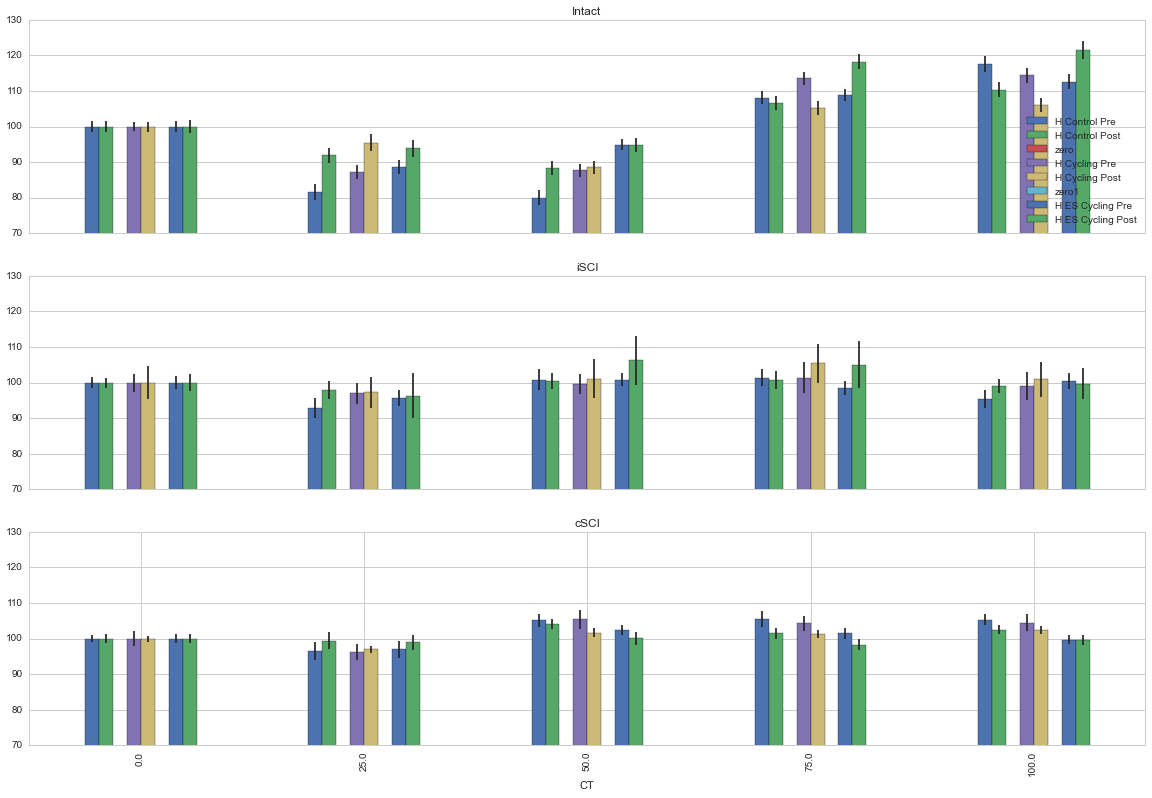

In [6]:
df = dmedian.reset_index()[['Group', 'CT', 
                  'H Control Pre', 
                  'H Cycling Pre', 
                  'H ES Cycling Pre',
                  'H Control Post',
                  'H Cycling Post',
                  'H ES Cycling Post']].copy()

df['zero'] = 0
df['zero1'] = 0
df = df[['Group', 'CT', 
                  'H Control Pre', 
                  'H Control Post',
                  'zero',
                  'H Cycling Pre', 
                  'H Cycling Post',
                  'zero1',
                  'H ES Cycling Pre',
                  'H ES Cycling Post']]

dmed = df

df = dmedian.reset_index()[['Group', 'CT', 
                  'H Control Pre sem', 
                  'H Cycling Pre sem', 
                  'H ES Cycling Pre sem',
                  'H Control Post sem',
                  'H Cycling Post sem',
                  'H ES Cycling Post sem']].copy()

df['zero'] = 0
df['zero1'] = 0
df = df[['Group', 'CT', 
                  'H Control Pre sem', 
                  'H Control Post sem',
                  'zero',
                  'H Cycling Pre sem', 
                  'H Cycling Post sem',
                  'zero1',
                  'H ES Cycling Pre sem',
                  'H ES Cycling Post sem']]

dsem = df.rename(columns={
        'H Control Pre sem': 'H Control Pre', 
        'H Control Post sem': 'H Control Post',
        'H Cycling Pre sem': 'H Cycling Pre',
        'H Cycling Post sem': 'H Cycling Post',
        'H ES Cycling Pre sem': 'H ES Cycling Pre',
        'H ES Cycling Post sem': 'H ES Cycling Post',
    })

fig_distr, (ax0, ax1, ax2) = plt.subplots(3,1, figsize=(20,13), dpi=200)
dm = dmed[dmed['Group'] == 'intact'].set_index('CT')
ds = dsem[dsem['Group'] == 'intact'].set_index('CT')

dm.plot(yerr=ds, subplots=False, kind='bar', title='Intact', ax=ax0, grid=True, legend=True, ylim=[70, 130])
#ax0.plot(df['CT'], df['H Control Pre'], linestyle='', marker='o', ms=12, label=df['UID'])
ax0.xaxis.set_visible(False)

dm = dmed[dmed['Group'] == 'isci'].set_index('CT')
ds = dsem[dsem['Group'] == 'isci'].set_index('CT')
dm.plot(yerr=ds, subplots=False, kind='bar', title='iSCI', ax=ax1, grid=True, legend=False, ylim=[70, 130])
#ax1.plot(df['CT'], df['H Control Post'], linestyle='', marker='o', ms=12)


ax1.xaxis.set_visible(False)

dm = dmed[dmed['Group'] == 'csci'].set_index('CT')
ds = dsem[dsem['Group'] == 'csci'].set_index('CT')
dm.plot(yerr=ds, subplots=False, kind='bar', title='cSCI', ax=ax2, grid=True, legend=False, ylim=[70,130])

In [7]:
df = df_allnorm.groupby(['Group', 'UID', 'CT']).median()
df = df.reset_index()

# Calculate changes
df['H Control changes'] = - 100 + 100 * df['H Control Post'] / df['H Control Pre'] #(dmedian['H Control Post'] - dmedian['H Control Pre']) #/ dmedian['H Control Pre']
df['H Cycling changes'] = - 100 + 100 * df['H Cycling Post'] / df['H Cycling Pre'] #(dmedian['H Cycling Post'] - dmedian['H Cycling Pre']) #/ dmedian['H Cycling Pre']
df['H ES Cycling changes'] = - 100 + 100 * df['H ES Cycling Post'] / df['H ES Cycling Pre'] #(dmedian['H ES Cycling Post'] - dmedian['H ES Cycling Pre']) #/ dmedian['H ES Cycling Pre']

df = df[['Group', 'UID', 'CT', 'H Control changes', 'H Cycling changes', 'H ES Cycling changes']]
dg = df.groupby(['Group', 'CT'])
dcmed = dg.median().reset_index()
dcsem = dg.sem().reset_index()

fig_changes, (ax0, ax1, ax2) = plt.subplots(3,1, figsize=(20,13), dpi=200)
dm = dcmed[dcmed['Group'] == 'intact'].set_index('CT')
ds = dcsem[dcsem['Group'] == 'intact'].set_index('CT')
dm.plot(yerr=ds, subplots=False, kind='bar', title='Intact', ax=ax0, grid=True, legend=True, ylim=[-15,50])
ax0.xaxis.set_visible(False)

dm = dcmed[dcmed['Group'] == 'isci'].set_index('CT')
ds = dcsem[dcsem['Group'] == 'isci'].set_index('CT')
dm.plot(yerr=ds, subplots=False, kind='bar', title='iSCI', ax=ax1, grid=True, legend=False, ylim=[-15,50])
ax1.xaxis.set_visible(False)

dm = dcmed[dcmed['Group'] == 'csci'].set_index('CT')
ds = dcsem[dcsem['Group'] == 'csci'].set_index('CT')
dm.plot(yerr=ds, subplots=False, kind='bar', title='cSCI', ax=ax2, grid=True, legend=False, ylim=[-15,50])

In [8]:
# Save figure
fig_changes.savefig('Statistical Analysis/using median all subjs/fig changes.eps', format='eps', dpi=600)
fig_distr.savefig('Statistical Analysis/using median all subjs/fig distr.eps', format='eps', dpi=600)